In [1]:
!nvidia-smi

Wed Jul  8 14:09:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/ifayost/AnDiAnomalousDiffusion.git
!cp "/content/drive/My Drive/AnDiAnomalousDiffusion/ref1.txt" "./"
!cp "/content/drive/My Drive/AnDiAnomalousDiffusion/task1.txt" "./"
!cp "/content/AnDiAnomalousDiffusion/transformers.py" "./"
!cp "/content/AnDiAnomalousDiffusion/utils.py" "./"

Cloning into 'AnDiAnomalousDiffusion'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 54 (delta 22), reused 31 (delta 10), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [3]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from transformers import Transformer, AdamWarmup
from utils import Series, test_analysis_alpha

random_num = 9

In [4]:
series = Series()
series.read("./task1.txt")

In [5]:
np.random.seed(random_num)
x,y,mask = series.get(range(10000),1,mask=True)
test_size = 0.3
random_indices = np.random.permutation(len(x))
xtr = x[:int(len(x)*(1-test_size))]
xtest = x[int(len(x)*(1-test_size)):]
ytr = y[:int(len(x)*(1-test_size))]
ytest = y[int(len(x)*(1-test_size)):]
masktr = mask[:int(len(x)*(1-test_size))]
masktest = mask[int(len(x)*(1-test_size)):]

In [12]:
BATCH_SIZE = 32
D_MODEL = 128
HEADS = 10
NUM_LAYERS = 2
MAX_LEN = xtr.shape[1]  

model = Transformer(D_MODEL, HEADS, NUM_LAYERS, MAX_LEN)
model = model.to(model.device)
criterion = nn.L1Loss()
adam_optimizer = torch.optim.Adam(model.parameters(), 
                                  betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = D_MODEL, 
                                   warmup_steps = 100000, 
                                   optimizer = adam_optimizer)

AssertionError: ignored

In [ ]:
def train(transformer, criterion, epoch):
  transformer.train()
  sum_loss = 0
  count = 0
  best_loss = 9999
  for i in np.arange(0,len(xtr), BATCH_SIZE):
    X = torch.Tensor(xtr[i : i+BATCH_SIZE])\
      .to(transformer.device).view(-1, 1, MAX_LEN)
    Y = torch.Tensor(ytr[i : i+BATCH_SIZE])\
      .to(transformer.device).view(-1, 1)
    M = torch.Tensor(masktr[i : i+BATCH_SIZE])\
      .to(transformer.device).view(-1, 1, MAX_LEN)
    out = transformer(X, M)
    loss = criterion(Y, out)
    transformer_optimizer.optimizer.zero_grad()
    loss.backward()
    transformer_optimizer.optimizer.step()
    samples = len(X)
    sum_loss += loss.item() * samples
    count += samples
    
    if i % 100 == 0:
      print("Epoch [{}][{}/{}]\tLoss: {:.3f}".format(epoch, i, 
                                                     len(xtr), sum_loss/count))
      if sum_loss/count < best_loss:
        torch.save(transformer.state_dict(), 
                   "/content/drive/My Drive/AnDiAnomalousDiffusion/weights.pt")
        best_loss = sum_loss/count
  return sum_loss/count

In [ ]:
hist = []
for epoch in range(10):
  hist.append(train(model, criterion, epoch))

Epoch [0][0/7000]	Loss: 0.339
Epoch [0][800/7000]	Loss: 0.361
Epoch [0][1600/7000]	Loss: 0.348


In [9]:
def test():
  model.eval()
  true = []
  pred = []
  with torch.no_grad():
    for i in np.arange(0,len(xtest), BATCH_SIZE):
      X = torch.Tensor(xtest[i : i + BATCH_SIZE]).to(model.device).view(-1, 1, MAX_LEN)
      Y = ytest[i : i + BATCH_SIZE]
      M = torch.Tensor(masktest[i : i + BATCH_SIZE]).to(model.device).view(-1, 1, MAX_LEN)
      out = model(X, M).view(-1)
      true.extend(Y)
      pred.extend(out.cpu().numpy())
  
  return np.array(true), np.array(pred)

true, pred = test()

MAE = 0.3361 



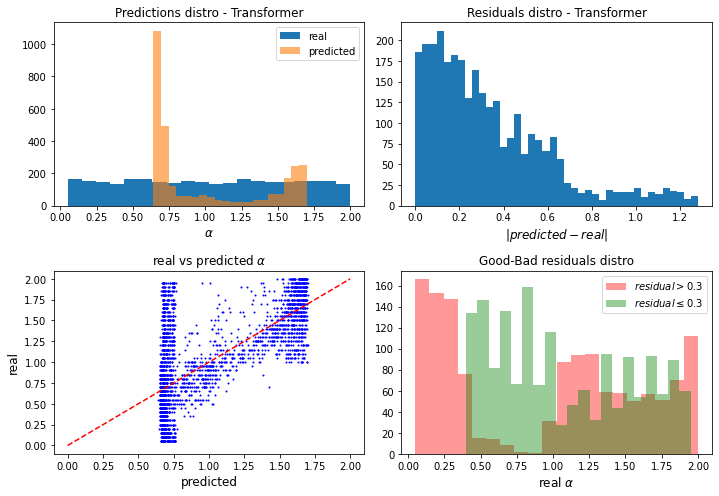

In [11]:
test_analysis_alpha(pred, true, algo = "Transformer",thres=0.3)